#Setup
Import libraries and data

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# run this if you are using colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# if this does not run, change to the file path where ALL is located on your device
!unzip gdrive/MyDrive/ALL.zip

Streaming output truncated to the last 5000 lines.
  inflating: ALL/all_pro/all_pro_4792.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_4792.jpg  
  inflating: ALL/all_pro/all_pro_1832.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_1832.jpg  
  inflating: ALL/all_pro/all_pro_0292.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_0292.jpg  
  inflating: ALL/all_pro/all_pro_3943.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_3943.jpg  
  inflating: ALL/all_pro/all_pro_2485.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_2485.jpg  
  inflating: ALL/all_pro/all_pro_3957.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_3957.jpg  
  inflating: ALL/all_pro/all_pro_2491.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_2491.jpg  
  inflating: ALL/all_pro/all_pro_0286.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_0286.jpg  
  inflating: ALL/all_pro/all_pro_1198.jpg  
  inflating: __MACOSX/ALL/all_pro/._all_pro_1198.jpg  
  inflating: ALL/all_pro/all_pro_1826.jpg  
  inflating: _

In [4]:
data_dir = 'ALL'

#Data Processing
Split data into training, validation, and testing sets

In [5]:
# training and validation sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # 70% train
    subset="training",
    seed=123,
    image_size=(128, 128),  # resize all images
    batch_size=32
)

temp_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3, # 30% temporary dataset
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

Found 20000 files belonging to 4 classes.
Using 14000 files for training.
Found 20000 files belonging to 4 classes.
Using 6000 files for validation.


In [6]:
# split temp_ds into val (50%) + test (50%) -> 15% each
# temp_ds originally has 6000 (files) / 32 (batch size) = 187.5 (round up = 188)
val_batches = tf.data.experimental.cardinality(temp_ds) # cardinality is the rounded number of batches
val_ds = temp_ds.take(val_batches // 2) # takes first half
test_ds = temp_ds.skip(val_batches // 2) # skips first half and takes second half

# expect cardinality = 94 (188 / 2)
print("Cardinality of validation set:", tf.data.experimental.cardinality(val_ds).numpy())
print("Cardinality of test set:", tf.data.experimental.cardinality(test_ds).numpy())

Cardinality of validation set: 94
Cardinality of test set: 94


In [7]:
# normalize the data so that values are [0,1] instead of [0,255]
# improves convergence speed and ensures consistency among all features
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

#CNN Models and Training Performance
Model implementation, training, and validation performance visualization


In [10]:
num_classes = 4  # benign, early, pre, pro
epochs = 15

# 2 convolution layers and a max pooling layer
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # multi-class
])

model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history1 = model1.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stopping])

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - accuracy: 0.6334 - loss: 1.3962 - val_accuracy: 0.9062 - val_loss: 0.2509
Epoch 2/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - accuracy: 0.9208 - loss: 0.2095 - val_accuracy: 0.9156 - val_loss: 0.2265
Epoch 3/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.9580 - loss: 0.1115 - val_accuracy: 0.9545 - val_loss: 0.1235
Epoch 4/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9821 - loss: 0.0543 - val_accuracy: 0.9441 - val_loss: 0.2787
Epoch 5/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.9631 - loss: 0.1086 - val_accuracy: 0.9628 - val_loss: 0.1150
Epoch 6/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.9896 - loss: 0.0357 - val_accuracy: 0.9591 - val_loss: 0.1297
Epoch 7/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.9938 - loss: 0.0199 - val_accuracy: 0.9681 - val_loss: 0.1201
Epoch 8/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.9969 - loss: 0.0117 - val_accurac

In [31]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,530,254 (360.60 MB)

 Trainable params: 31,510,084 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,020,170 (240.40 MB)

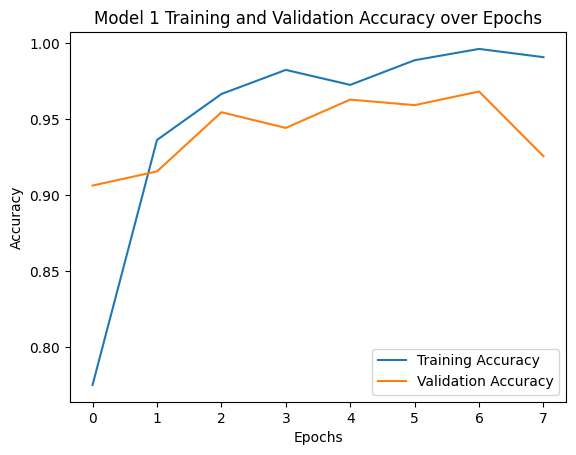

In [19]:
train_acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']
epochs_trained = len(train_acc1)

plt.plot(range(epochs_trained), train_acc1, label='Training Accuracy')
plt.plot(range(epochs_trained), val_acc1, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model 1 Training and Validation Accuracy over Epochs")
plt.legend()
plt.show()

In [17]:
# 2 convolution layers and a max pooling layer and 25% dropout
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # multi-class
])

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history2 = model2.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stopping])

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.6004 - loss: 1.7484 - val_accuracy: 0.9043 - val_loss: 0.2452
Epoch 2/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.8995 - loss: 0.2758 - val_accuracy: 0.8943 - val_loss: 0.2921
Epoch 3/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.8926 - loss: 0.3021 - val_accuracy: 0.9408 - val_loss: 0.1616
Epoch 4/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.9672 - loss: 0.0938 - val_accuracy: 0.8687 - val_loss: 0.4155
Epoch 5/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.9608 - loss: 0.1257 - val_accuracy: 0.9378 - val_loss: 0.1959
Epoch 6/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.9836 - loss: 0.0568 - val_accuracy: 0.9428 - val_loss: 0.1693


In [32]:
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,530,254 (360.60 MB)

 Trainable params: 31,510,084 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,020,170 (240.40 MB)

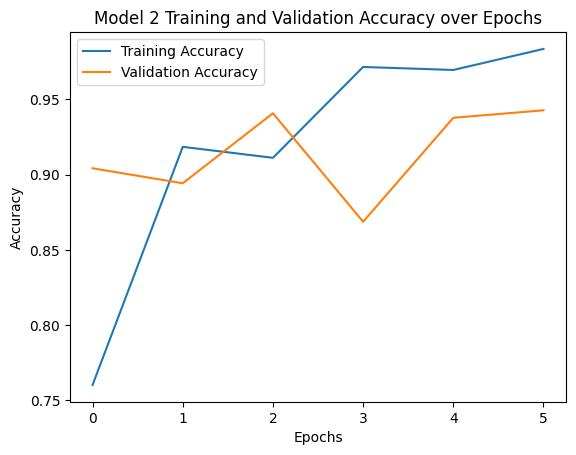

In [18]:
train_acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
epochs_trained = len(train_acc2)

plt.plot(range(epochs_trained), train_acc2, label='Training Accuracy')
plt.plot(range(epochs_trained), val_acc2, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model 2 Training and Validation Accuracy over Epochs")
plt.legend()
plt.show()

# Make Predictions



In [22]:
# Model predictions
predictions1 = model1.predict(test_ds)
predicted_labels1 = np.argmax(predictions1, axis=1)

predictions2 = model2.predict(test_ds)
predicted_labels2 = np.argmax(predictions2, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step


#Generating and Plotting Confusion Matrices

In [23]:
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

In [27]:
# Generate confusion matrices for model performance
cm1 = confusion_matrix(true_labels, predicted_labels1)
cm2 = confusion_matrix(true_labels, predicted_labels2)

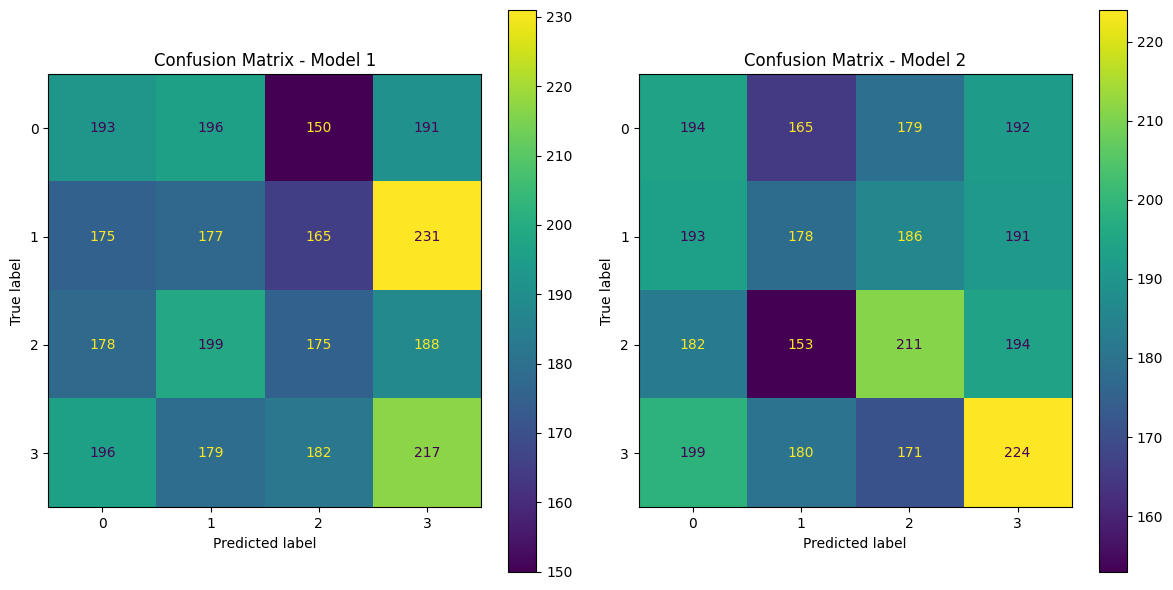

In [29]:
# Plotting confusion matrices for each model
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=[0, 1, 2, 3])
disp1.plot(ax=axes[0])
axes[0].set_title('Confusion Matrix - Model 1')

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=[0, 1, 2, 3])
disp2.plot(ax=axes[1])
axes[1].set_title('Confusion Matrix - Model 2')

plt.tight_layout()
plt.show()

#Visualizing a CNN layer applied to a single image

In [41]:
# Take one batch from the test dataset
for images, labels in train_ds.take(1):
    # Select the first image from the batch
    sample_image = images[0]
    # Expand dimensions to create a batch of size 1
    sample_image = tf.expand_dims(sample_image, axis=0)

print(sample_image.shape)

(1, 128, 128, 3)


# Extract the output of the convolutional layer
Create a new model that outputs the result of the chosen convolutional layer and apply the filter to the sample image


In [42]:
conv_layer_name = 'conv2d_2'
feature_map_model = tf.keras.models.Model(inputs=model1.inputs, outputs=model1.get_layer(conv_layer_name).output)
feature_map_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896 (3.50 KB)

 Trainable params: 896 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
feature_maps = feature_map_model.predict(sample_image)
print(feature_maps.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
(1, 126, 126, 32)


#Visualize the generated feature maps

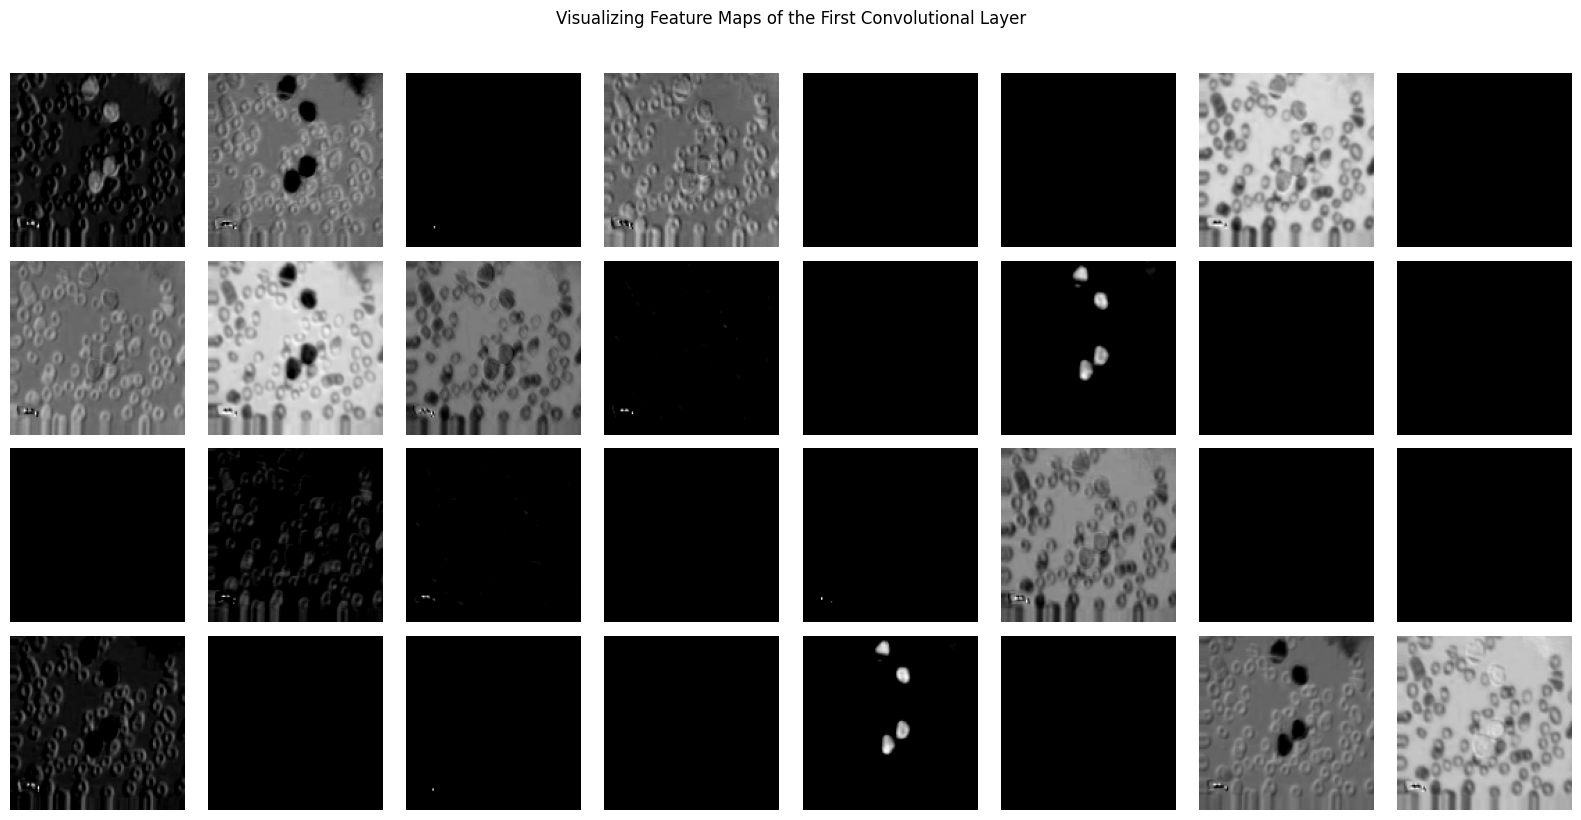

In [44]:
num_feature_maps = feature_maps.shape[-1]
cols = 8
rows = (num_feature_maps + cols - 1) // cols

plt.figure(figsize=(cols * 2, rows * 2))

for i in range(num_feature_maps):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(feature_maps[0, :, :, i], cmap='gray') # Display the i-th feature map
    plt.axis('off')

plt.suptitle("Visualizing Feature Maps of the First Convolutional Layer", y=1.02)
plt.tight_layout()
plt.show()